In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import pyvista as pv
from desmin_reconstruction.analysis.z_line_detection import (
    detect_Z_lines,
    nearest_Z_line_distances,
)
from desmin_reconstruction.plotting import clustered_scatterplot, line_and_bandplot
from desmin_reconstruction.plotting.renderings import (
    render_boundingsquare,
    render_pointcloud,
)
from desmin_reconstruction.preprocessing.bbox import BoundingSquare, filter_bounded
from desmin_reconstruction.preprocessing.storm import align_patch
from hdbscan import HDBSCAN
from tqdm import tqdm


pv.set_jupyter_backend("static")


LABEL_DICT = {"desmin": "Desmin", "actinin": "α-actinin"}
COLOR_DICT = {"desmin": "#FF0000", "actinin": "#00FF00"}
scatter_kwargs = {"alpha": 0.3, "s": 0.2}

In [2]:
df = pl.read_csv("../data/results/desmin_alphaactinin_600nm_aligned.csv")
out = df.partition_by("probe")

points = {
    name: out[i].select(["x", "y", "z"]).to_numpy()
    for i, name in enumerate(("desmin", "actinin"))
}
points["desmin"].shape

(59957, 3)

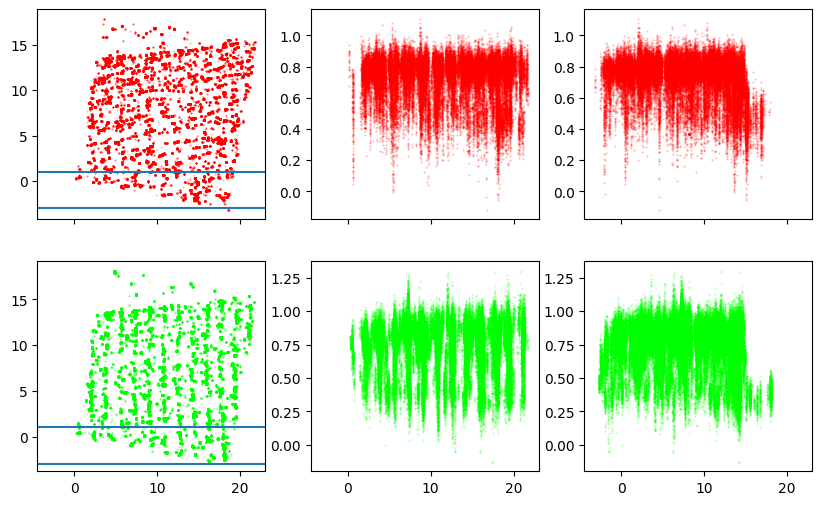

In [3]:
fig, axes = plt.subplots(2, 3, figsize=(10, 6), sharex=True)
for i, protein in enumerate(("desmin", "actinin")):
    for j, (ax1, ax2) in enumerate(((0, 1), (0, 2), (1, 2))):
        axes[i, j].scatter(
            points[protein][:, ax1],
            points[protein][:, ax2],
            c=COLOR_DICT[protein],
            **scatter_kwargs,
        )
for ax in axes[:, 0]:
    ax.axhline(y=1)
    ax.axhline(y=-3)

In [4]:
x0s = (2, 6, 10, 14, 18, 1, 5, 9, 13, 17, 0, 4, 8, 12, 16, 15)
y0s = (9, 9, 9, 9, 9, 5, 5, 5, 5, 5, 1, 1, 1, 1, 1, -3)
bboxes = [BoundingSquare(x0, y0, side=4) for x0, y0 in zip(x0s, y0s)]

In [5]:
idx = 12
bbox = bboxes[idx]
sq1 = {k: filter_bounded(v, bbox) for k, v in points.items()}

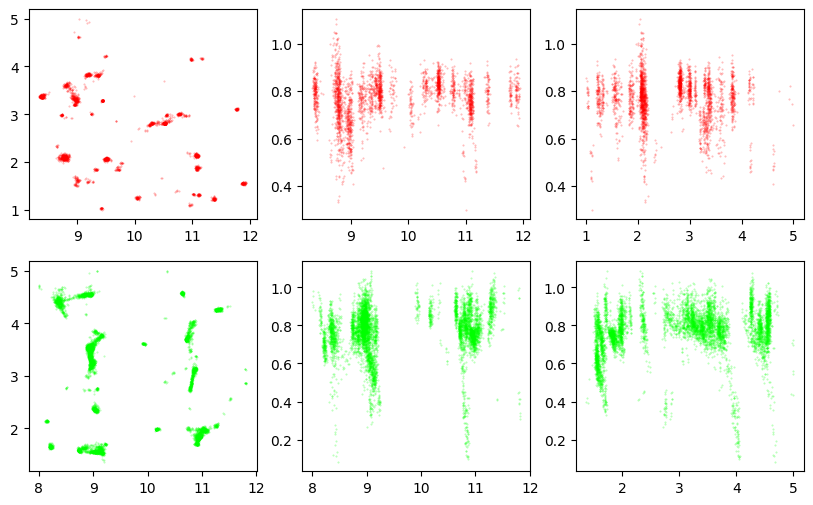

In [6]:
fig, axes = plt.subplots(2, 3, figsize=(10, 6))
for i, protein in enumerate(("desmin", "actinin")):
    for j, (ax1, ax2) in enumerate(((0, 1), (0, 2), (1, 2))):
        axes[i, j].scatter(
            sq1[protein][:, ax1],
            sq1[protein][:, ax2],
            c=COLOR_DICT[protein],
            **scatter_kwargs,
        )


100%|██████████| 80/80 [00:11<00:00,  6.69it/s]


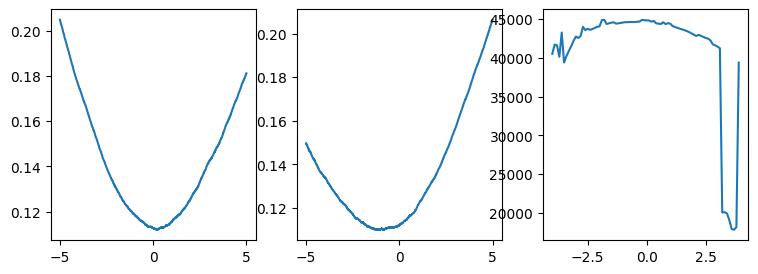

In [7]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    transform_fn_sq, metrics_sq = align_patch(
        sq1,
        tilt_sweep_values=np.arange(-5, 5, 0.001),
        rotation_sweep_values=np.arange(-4, 4, 0.1),
        min_cluster_size=500,
        min_samples=10,
    )

fig, axes = plt.subplots(1, len(metrics_sq), figsize=(9, 3))
for ax, metric in zip(axes, metrics_sq):
    ax.plot(*metric)

### For a single ROI, locate the Z band

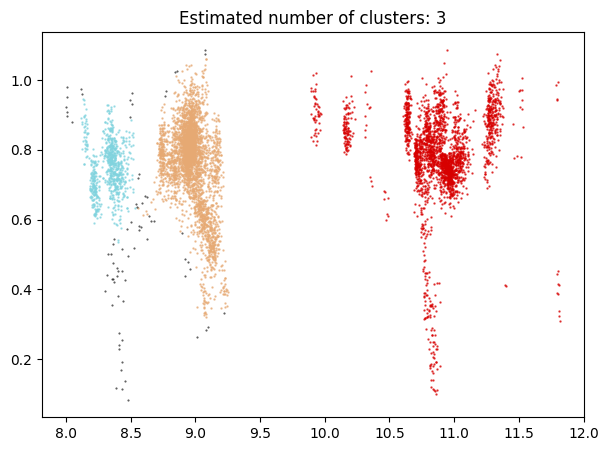

In [8]:
clusterer = HDBSCAN(min_cluster_size=500, min_samples=10)
xz = sq1["actinin"][:, np.array([0, 2])]
clusterer.fit(xz)
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax = clustered_scatterplot(ax, xz, clusterer.labels_)

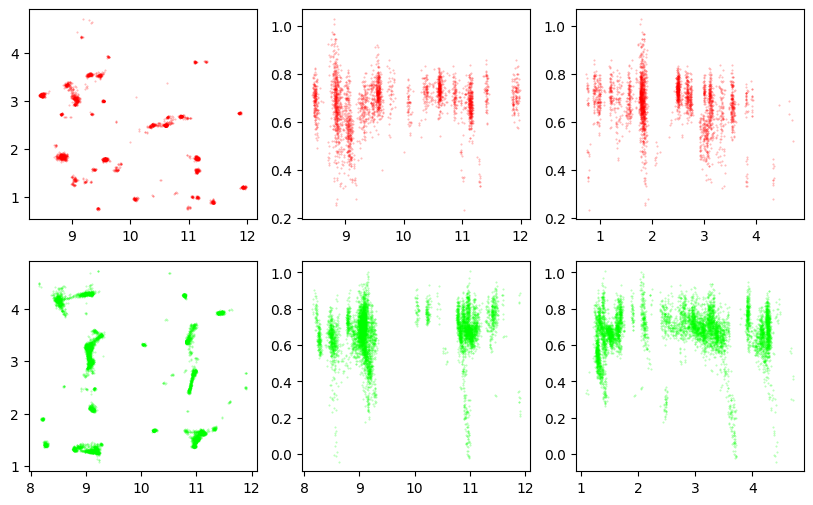

In [9]:
sq1_final = {k: transform_fn_sq(v) for k, v in sq1.items()}
scatter_kwargs = {"alpha": 0.3, "s": 0.2}
COLOR_DICT = {"desmin": "#FF0000", "actinin": "#00FF00"}
fig, axes = plt.subplots(2, 3, figsize=(10, 6))
for i, protein in enumerate(("desmin", "actinin")):
    for j, (ax1, ax2) in enumerate(((0, 1), (0, 2), (1, 2))):
        axes[i, j].scatter(
            sq1_final[protein][:, ax1],
            sq1_final[protein][:, ax2],
            c=COLOR_DICT[protein],
            **scatter_kwargs,
        )


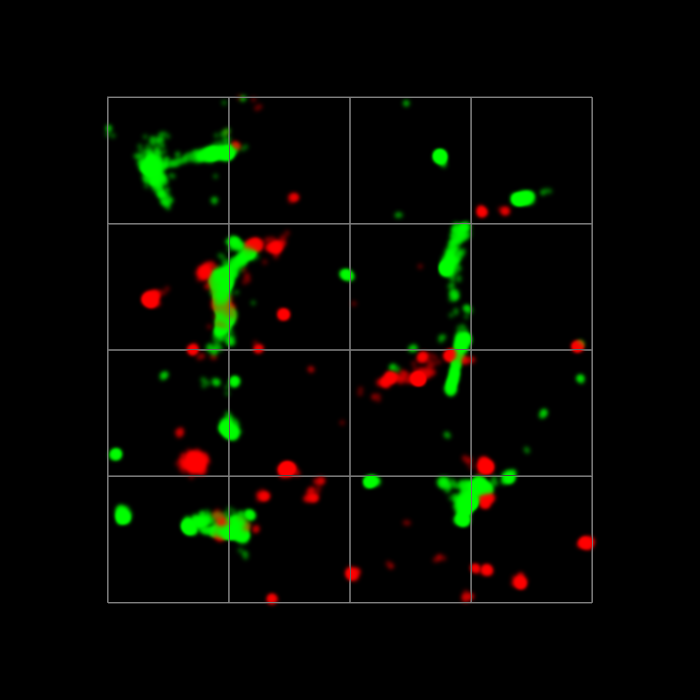

In [11]:
p = pv.Plotter(notebook=True, window_size=(700, 700))
for protein in ("desmin", "actinin"):
    point_cloud = pv.PolyData(sq1_final[protein])
    point_cloud = point_cloud.project_points_to_plane(
        origin=[0, 0, 0], normal=[0, 0, 1]
    )
    p.add_mesh(
        point_cloud,
        color=COLOR_DICT[protein],
        style="points_gaussian",
        # emissive=True,
        point_size=5,
        opacity=0.2,
    )

p.set_background(color="black")
p.enable_parallel_projection()

p.view_xy()
axis = p.show_bounds(
    color="#888888",
    grid="back",
    bold=False,
    font_size=20,
    font_family="arial",
    padding=0.0,
    use_3d_text=False,
    show_zaxis=False,
    xtitle="",
    ytitle="",
)
axis.x_axis_label_visibility = False
axis.y_axis_label_visibility = False
axis.z_axis_label_visibility = False
# p.camera.tight(padding=0.2)
p.show()
p.save_graphic("../figures/fig_2/projection_2d.svg")

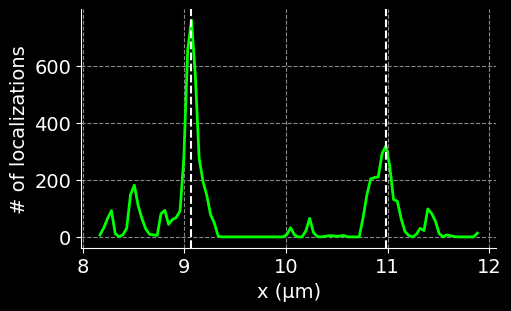

In [16]:
plt.style.use("dark_background")
plt.rc("font", size=14)

sarco_pos, distribution = detect_Z_lines(sq1_final["actinin"])
fig, ax = plt.subplots(1, 1, figsize=(5, 3), constrained_layout=True)
ax.plot(*distribution, color=COLOR_DICT["actinin"], linewidth=2.0)
for pos in sarco_pos:
    ax.axvline(pos, ls="--", color="white")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(ls="--", color="#888888")
ax.set_xlabel("x (μm)")
ax.set_ylabel("# of localizations")
fig.savefig("../figures/fig_2/count_distribution.svg", dpi=500)

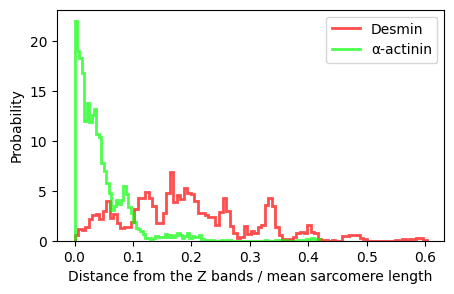

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
sq_sarco_dists = {
    k: nearest_Z_line_distances(v, sarco_pos) for k, v in sq1_final.items()
}

for name, dist in sq_sarco_dists.items():
    ax.stairs(
        *np.histogram(
            dist,
            bins=100,
            density=True,
        ),
        alpha=0.7,
        linewidth=2.0,
        color=COLOR_DICT[name],
        label=LABEL_DICT[name],
    )

ax.set_xlabel("Distance from the Z bands / mean sarcomere length")
ax.set_ylabel("Probability")
# ax.set_xlim((-0.02, 0.52))
ax.legend()

In [17]:
sarcomere_distances = []
for roi in tqdm(bboxes):
    sq1 = {k: filter_bounded(v, roi) for k, v in points.items()}

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        transform_fn_sq, _ = align_patch(
            sq1,
            tilt_sweep_values=np.arange(-5, 5, 0.001),
            rotation_sweep_values=np.arange(-4, 4, 0.1),
            min_cluster_size=500,
            min_samples=10,
        )
    sq1_final = {k: transform_fn_sq(v) for k, v in sq1.items()}
    sarco_pos, _ = detect_Z_lines(sq1_final["actinin"])
    sq_sarco_dists = {
        k: nearest_Z_line_distances(v, sarco_pos) for k, v in sq1_final.items()
    }
    sarcomere_distances.append(sq_sarco_dists)

100%|██████████| 16/16 [05:55<00:00, 22.20s/it]


In [18]:
dist_bins = np.linspace(0, 1.0, 200)
hist_counts = {
    k: [
        np.histogram(dist_dict[k], bins=dist_bins, density=True)[0]
        for dist_dict in sarcomere_distances
    ]
    for k in ("desmin", "actinin")
}

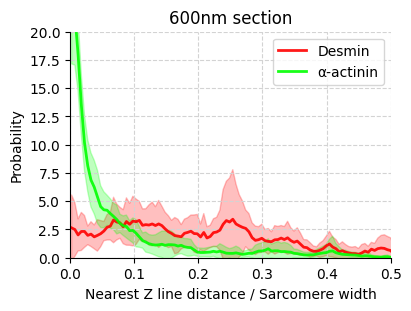

In [27]:
plt.rc("font", size=15)
plt.style.use("default")
fig, ax = plt.subplots(1, 1, figsize=(4, 3), constrained_layout=True)
for protein, distances in hist_counts.items():
    ax = line_and_bandplot(
        ax,
        (dist_bins[:-1] + dist_bins[1:]) / 2,
        np.mean(distances, axis=0),
        np.std(distances, axis=0),
        color=COLOR_DICT[protein],
        label=LABEL_DICT[protein],
        linewidth=2.0,
        alpha=0.9,
        alpha_band=0.25,
    )
ax.set_xlim((0, 0.5))
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(ls="--", color="lightgray")
ax.set_xlabel("Nearest Z line distance / Sarcomere width")
ax.set_ylabel("Probability")
ax.legend(loc="upper right")
ax.set_ylim((0, 20))
ax.set_title("600nm section")
fig.savefig("../figures/fig_2/z_line_distances_600nm.svg", dpi=500)

## Repeat analysis for 2.5um stack

In [2]:
df = pl.read_csv("../data/results/desmin_alphaactinin_2.5um_small_aligned.csv")
out = df.partition_by("probe")

points = {
    name: out[i].select(["x", "y", "z"]).to_numpy()
    for i, name in enumerate(("desmin", "actinin"))
}
points["desmin"].shape

(111368, 3)

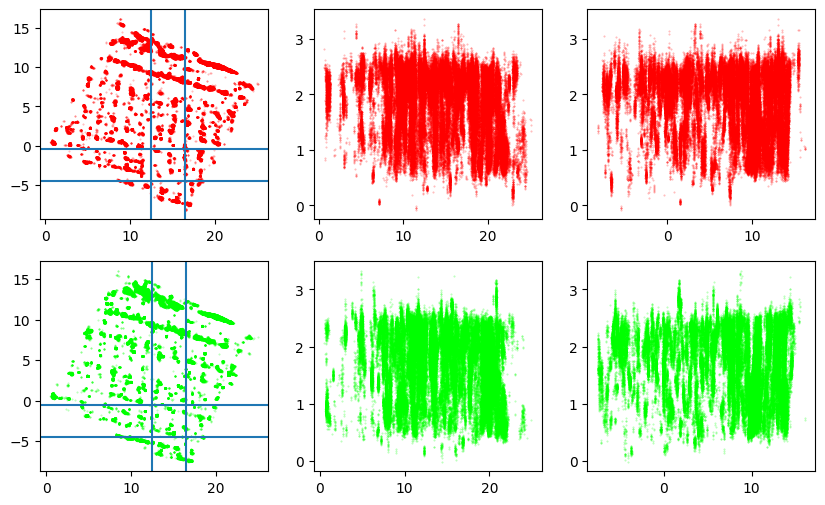

In [3]:
fig, axes = plt.subplots(2, 3, figsize=(10, 6))
for i, protein in enumerate(("desmin", "actinin")):
    for j, (ax1, ax2) in enumerate(((0, 1), (0, 2), (1, 2))):
        axes[i, j].scatter(
            points[protein][:, ax1],
            points[protein][:, ax2],
            c=COLOR_DICT[protein],
            **scatter_kwargs,
        )

bbox = BoundingSquare(x0=12.5, y0=-4.5, side=4)
for ax in axes[:, 0]:
    ax.axhline(y=bbox.y0)
    ax.axhline(y=bbox.y1)
    ax.axvline(x=bbox.x0)
    ax.axvline(x=bbox.x1)


In [ ]:
x0s = (18.5, 16.5, 14.5, 14.5, 12.5, 10.5, 8.5, 6.5, 4.5, 2.5, 0.5, 4.5)
y0s = (2.0, -2.0, -6.0, 2.0, -2.0, 2.0, -2.0, 2.0, -2.0, 2.0, -2.0, 6.0)
bboxes = [BoundingSquare(x0, y0, side=4) for x0, y0 in zip(x0s, y0s)]

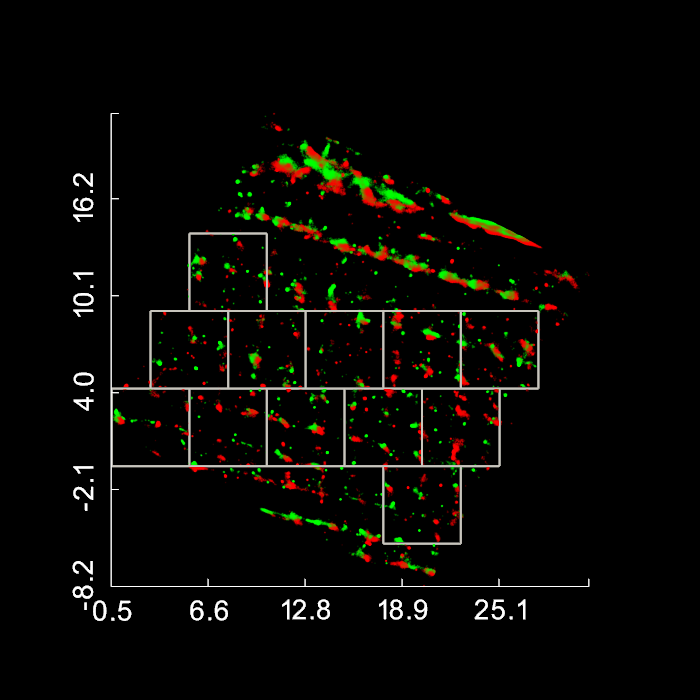

In [144]:
p = pv.Plotter(notebook=True, window_size=(700, 700))
for name, coords in points.items():
    p = render_pointcloud(p, coords, color=COLOR_DICT[name], opacity=0.2)

for bbox in bboxes:
    p = render_boundingsquare(p, bbox, line_width=2.0, color="white", z_height=10.0)

p.enable_parallel_projection()
p.view_xy()

p.show_bounds(
    color="white",
    grid=None,
    bold=False,
    font_size=22,
    font_family="arial",
    padding=0.0,
    use_3d_text=False,
    show_zaxis=False,
    xtitle="",
    ytitle="",
)


p.show()

In [145]:
idx = 11
bbox = bboxes[idx]
sq1 = {k: filter_bounded(v, bbox) for k, v in points.items()}

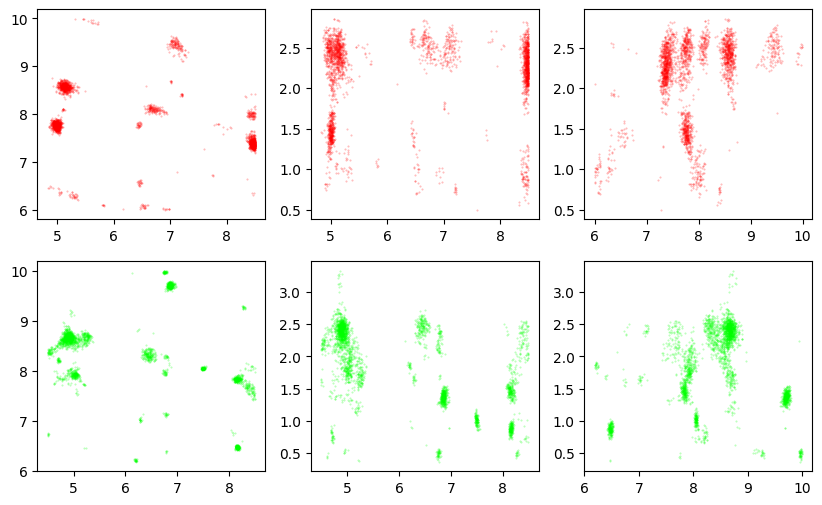

In [146]:
fig, axes = plt.subplots(2, 3, figsize=(10, 6))
for i, protein in enumerate(("desmin", "actinin")):
    for j, (ax1, ax2) in enumerate(((0, 1), (0, 2), (1, 2))):
        axes[i, j].scatter(
            sq1[protein][:, ax1],
            sq1[protein][:, ax2],
            c=COLOR_DICT[protein],
            **scatter_kwargs,
        )


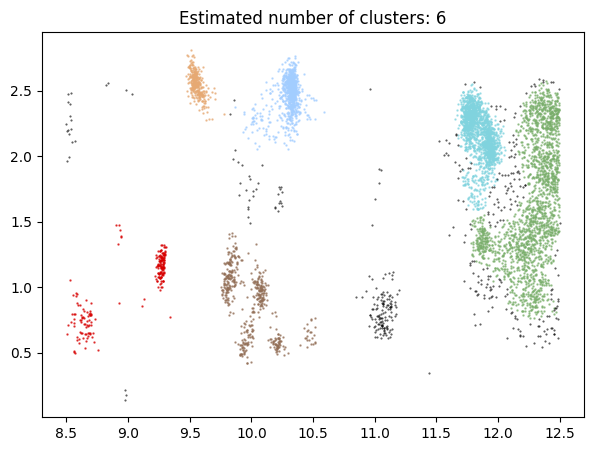

In [138]:
clusterer = HDBSCAN(min_cluster_size=200, min_samples=10)
xz = sq1["actinin"][:, np.array([0, 2])]
clusterer.fit(xz)
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax = clustered_scatterplot(ax, xz, clusterer.labels_)

100%|██████████| 25/25 [00:01<00:00, 12.55it/s]


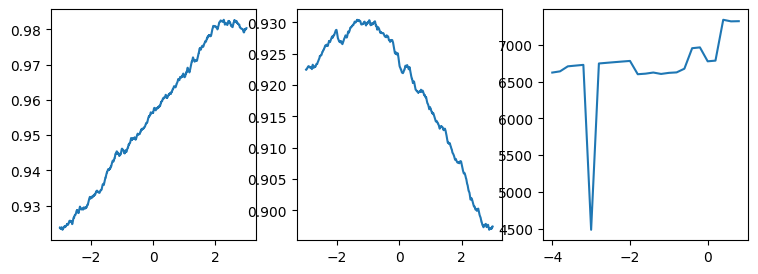

In [147]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    transform_fn_sq, metrics_sq = align_patch(
        sq1,
        tilt_sweep_values=np.arange(-3, 3, 0.001),
        rotation_sweep_values=np.arange(-4, 1, 0.2),
        min_cluster_size=200,
        min_samples=10,
    )

fig, axes = plt.subplots(1, len(metrics_sq), figsize=(9, 3))
for ax, metric in zip(axes, metrics_sq):
    ax.plot(*metric)

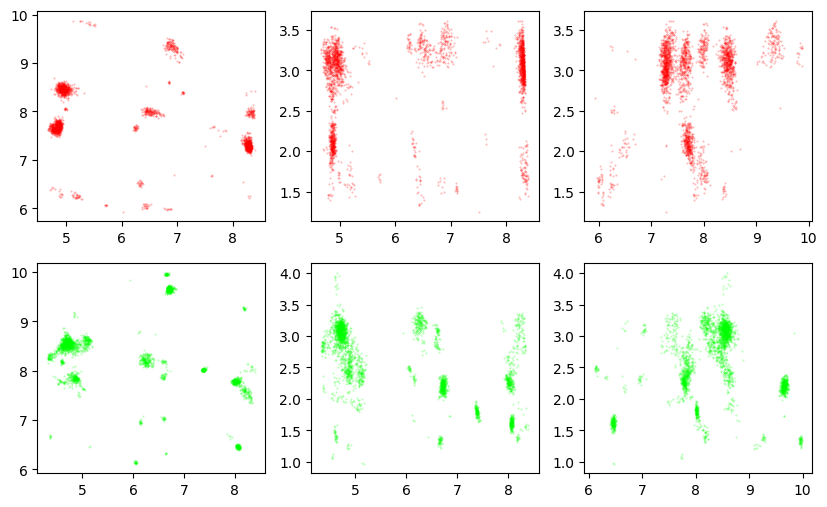

In [148]:
sq1_final = {k: transform_fn_sq(v) for k, v in sq1.items()}
scatter_kwargs = {"alpha": 0.3, "s": 0.2}
COLOR_DICT = {"desmin": "#FF0000", "actinin": "#00FF00"}
fig, axes = plt.subplots(2, 3, figsize=(10, 6))
for i, protein in enumerate(("desmin", "actinin")):
    for j, (ax1, ax2) in enumerate(((0, 1), (0, 2), (1, 2))):
        axes[i, j].scatter(
            sq1_final[protein][:, ax1],
            sq1_final[protein][:, ax2],
            c=COLOR_DICT[protein],
            **scatter_kwargs,
        )


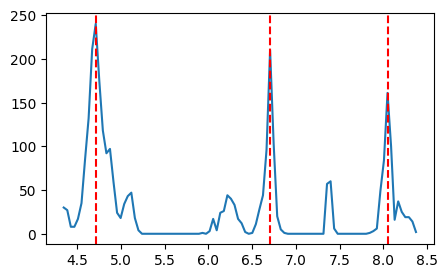

In [149]:
sarco_pos, distribution = detect_Z_lines(sq1_final["actinin"])
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.plot(*distribution)
for pos in sarco_pos:
    ax.axvline(pos, ls="--", color="red")

Text(0.5, 1.0, '2.5um ROI #11')

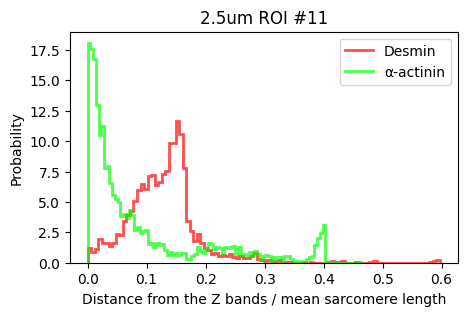

In [150]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
sq_sarco_dists = {
    k: nearest_Z_line_distances(v, sarco_pos) for k, v in sq1_final.items()
}


LABEL_DICT = {"desmin": "Desmin", "actinin": "α-actinin"}
COLOR_DICT = {"desmin": "#FF0000", "actinin": "#00FF00"}
for name, dist in sq_sarco_dists.items():
    ax.stairs(
        *np.histogram(
            dist,
            bins=100,
            density=True,
        ),
        alpha=0.7,
        linewidth=2.0,
        color=COLOR_DICT[name],
        label=LABEL_DICT[name],
    )

ax.set_xlabel("Distance from the Z bands / mean sarcomere length")
ax.set_ylabel("Probability")
# ax.set_xlim((-0.02, 0.52))
ax.legend()
ax.set_title(f"2.5um ROI #{idx}")

In [151]:
sarcomere_distances = []
for roi in tqdm(bboxes):
    sq1 = {k: filter_bounded(v, roi) for k, v in points.items()}

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        transform_fn_sq, _ = align_patch(
            sq1,
            tilt_sweep_values=np.arange(-3, 3, 0.001),
            rotation_sweep_values=np.arange(-4, 1, 0.2),
            min_cluster_size=200,
            min_samples=10,
        )
    sq1_final = {k: transform_fn_sq(v) for k, v in sq1.items()}
    sarco_pos, _ = detect_Z_lines(sq1_final["actinin"])
    sq_sarco_dists = {
        k: nearest_Z_line_distances(v, sarco_pos) for k, v in sq1_final.items()
    }
    sarcomere_distances.append(sq_sarco_dists)

100%|██████████| 12/12 [01:15<00:00,  6.33s/it]


In [153]:
dist_bins = np.linspace(0, 1.0, 200)
hist_counts = {
    k: [
        np.histogram(dist_dict[k], bins=dist_bins, density=True)[0]
        for dist_dict in sarcomere_distances
    ]
    for k in ("desmin", "actinin")
}

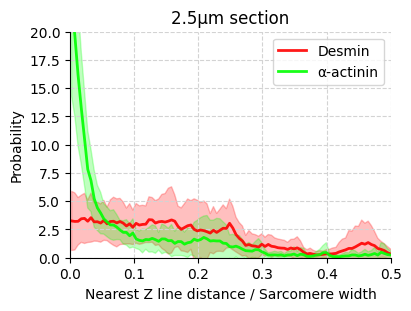

In [155]:
plt.rc("font", size=15)
plt.style.use("default")
fig, ax = plt.subplots(1, 1, figsize=(4, 3), constrained_layout=True)
for protein, distances in hist_counts.items():
    ax = line_and_bandplot(
        ax,
        (dist_bins[:-1] + dist_bins[1:]) / 2,
        np.mean(distances, axis=0),
        np.std(distances, axis=0),
        color=COLOR_DICT[protein],
        label=LABEL_DICT[protein],
        linewidth=2.0,
        alpha=0.9,
        alpha_band=0.25,
    )
ax.set_xlim((0, 0.5))
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(ls="--", color="lightgray")
ax.set_xlabel("Nearest Z line distance / Sarcomere width")
ax.set_ylabel("Probability")
ax.legend(loc="upper right")
ax.set_ylim((0, 20))
ax.set_title("2.5μm section")
fig.savefig("../figures/fig_2/z_line_distances_2.5um.svg", dpi=500)

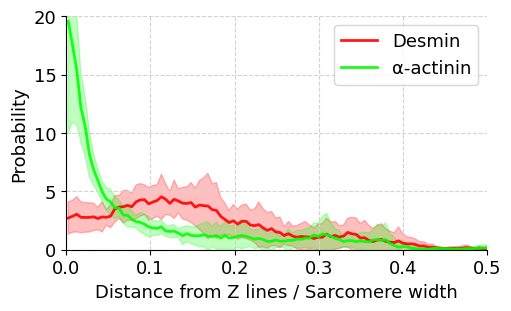

In [219]:
plt.rc("font", size=13)
fig, ax = plt.subplots(1, 1, figsize=(5, 3), constrained_layout=True)
for protein, distances in hist_counts.items():
    ax = line_and_bandplot(
        ax,
        (dist_bins[:-1] + dist_bins[1:]) / 2,
        np.mean(distances, axis=0),
        np.std(distances, axis=0),
        color=COLOR_DICT[protein],
        label=LABEL_DICT[protein],
        linewidth=2.0,
        alpha=0.9,
        alpha_band=0.25,
    )
ax.set_xlim((0, 0.5))
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(ls="--", color="lightgray")
ax.set_xlabel("Distance from Z lines / Sarcomere width")
ax.set_ylabel("Probability")
ax.legend(loc="upper right")
ax.set_ylim((0, 20))
fig.savefig("../figures/fig_2/z_line_distances_2.5um.svg", dpi=500)